### Time Series Forecasting using LSTM and GRU
In this notebook will use LSTM & GRU for predicting the price of stocks of Google for the year 2017

## Importing the libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.optimizers import SGD
from sklearn.metrics import mean_squared_error

## Helper Functions for Plotting Predictions and Calculating RMSE

In [40]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real GOOGL Stock Price')
    plt.plot(predicted, color='blue',label='Predicted GOOGL Stock Price')
    plt.title('GOOGL Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('GOOGL Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

## Getting the data

-If there are datetime columns in your CSV file, use the parse_dates parameter when reading CSV file with pandas. This reduces one extra step to convert these columns from string to datetime after reading the file.


-index_col: This is to allow you to set which columns to be used as the index of the dataframe. The default value is None, and pandas will add a new column start from 0 to specify the index column. It can be set as a column name or column index.

In [4]:
# First, we get the data
dataset = pd.read_csv('/content/drive/MyDrive/T5 Bootcamp/Dataset/week_5/Copy of GOOGL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL
...,...,...,...,...,...,...
2017-12-22,1070.00,1071.72,1067.64,1068.86,889446,GOOGL
2017-12-26,1068.64,1068.86,1058.64,1065.85,918767,GOOGL
2017-12-27,1066.60,1068.27,1058.38,1060.20,1116203,GOOGL


In [10]:
dataset.shape

(3019, 6)

In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2006-01-03 to 2017-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3019 non-null   float64
 1   High    3019 non-null   float64
 2   Low     3019 non-null   float64
 3   Close   3019 non-null   float64
 4   Volume  3019 non-null   int64  
 5   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 229.6+ KB


# Slpitting dataset to train set (Before 2017) and test set (2017 and beyond)


* iloc: This is a pandas method that stands for "integer-location based indexing." It allows you to select rows and columns by their integer positions (i.e., their index numbers).

* : This colon symbol means "select all rows" when used in the row position.
1:2: This slice selects columns by index. In this case, it selects the column at index 1. The range 1:2 includes the start index (1) but excludes the end index (2), meaning it selects only the column at index 1.

* .values: This converts the selected data into a NumPy array, which is a common format for numerical data in Python.

In [5]:
training_set = dataset[ : '2016'].iloc[ : ,1:2].values

In [6]:
training_set

array([[218.05],
       [224.7 ],
       [226.  ],
       ...,
       [813.33],
       [805.75],
       [803.28]])

In [7]:
test_set = dataset['2017': ].iloc[ : , 1:2].values

In [8]:
test_set

array([[ 811.44],
       [ 813.43],
       [ 813.74],
       [ 828.96],
       [ 830.43],
       [ 829.41],
       [ 829.9 ],
       [ 830.38],
       [ 834.65],
       [ 830.18],
       [ 829.81],
       [ 833.  ],
       [ 829.24],
       [ 845.54],
       [ 851.52],
       [ 858.79],
       [ 861.  ],
       [ 867.  ],
       [ 837.23],
       [ 823.07],
       [ 824.  ],
       [ 824.56],
       [ 826.13],
       [ 822.39],
       [ 831.92],
       [ 834.25],
       [ 831.98],
       [ 837.15],
       [ 841.74],
       [ 842.  ],
       [ 841.77],
       [ 842.69],
       [ 846.94],
       [ 852.2 ],
       [ 853.79],
       [ 852.62],
       [ 848.36],
       [ 850.67],
       [ 848.83],
       [ 858.  ],
       [ 856.49],
       [ 850.82],
       [ 848.94],
       [ 853.33],
       [ 856.93],
       [ 860.71],
       [ 864.23],
       [ 867.13],
       [ 867.58],
       [ 869.88],
       [ 872.71],
       [ 874.42],
       [ 870.34],
       [ 873.47],
       [ 855.35],
       [ 8

In [9]:
training_set.shape, test_set.shape

((2768, 1), (251, 1))

Visualizing the data

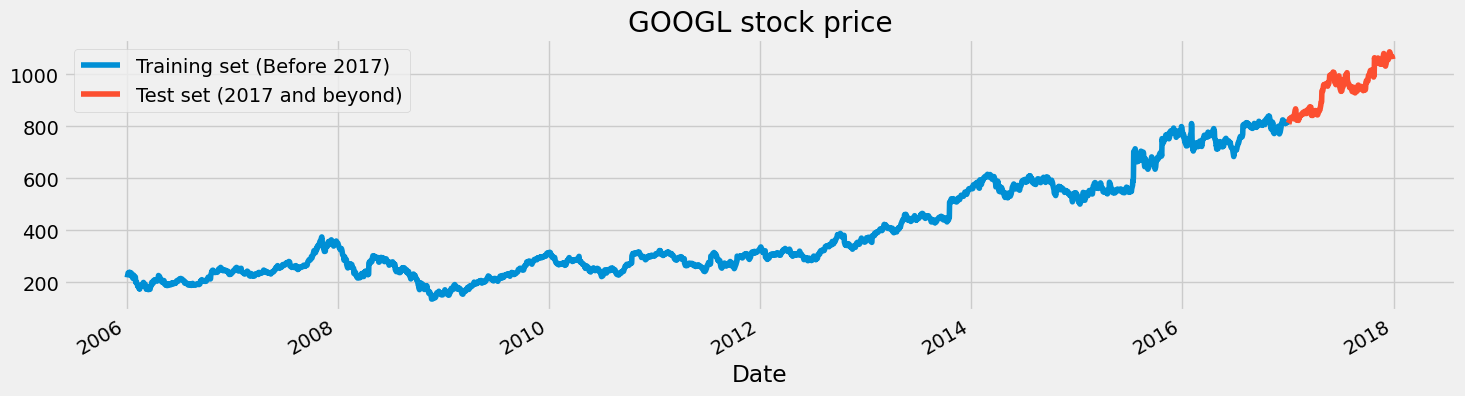

In [16]:
# We have chosen 'High' attribute for prices.
dataset["High"][:'2016'].plot(figsize=(16,4))
dataset["High"]['2017':].plot(figsize=(16,4))
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('GOOGL stock price')
plt.show()

## Data Preprocessing

Scaling the training set

In [17]:
scaler = MinMaxScaler()
training_set_scaled = scaler.fit_transform(training_set)

In [25]:
training_set_scaled # 2D array

array([[0.11819421],
       [0.12763782],
       [0.12948394],
       ...,
       [0.96354625],
       [0.95278196],
       [0.94927433]])

Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output. So for each element of training set, we have 60 previous training set elements

In [26]:
# These will store the input sequences and corresponding output values for the training data.
X_train = []
y_train = []

for i in range(60,2768):
  # This process creates a moving window of 60 time steps that will be used as input for the model.
    X_train.append(training_set_scaled[i-60:i,0])
  # This value is what the model will try to predict based on the preceding 60 time steps.
    y_train.append(training_set_scaled[i,0])

  #  The X_train and y_train lists are converted to NumPy arrays. This is necessary most mdels require input data to be in NumPy array format.
X_train, y_train = np.array(X_train), np.array(y_train)

Reshaping X_train for efficient modelling

The np.reshape operation transforms the X_train data into the required format for an RNN/LSTM model. Each sample in X_train becomes a 3D array of shape (samples, time steps, features), which is crucial for the model to correctly interpret and learn from the sequential data.

In [27]:
# X_train.shape == (number_of_samples, time_steps, number_of_features)
# X_train.shape == (2708, 60, 1)
X_train = np.reshape( X_train,( X_train.shape[0], X_train.shape[1], 1 ) )

## LSTM Model

In [28]:
model = Sequential()

# First LSTM layer with Dropout regularisation
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1) ))

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Fourth LSTM layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# The output layer
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [31]:
model.compile(optimizer='rmsprop', loss='mean_squared_error')

In [33]:
model.fit(X_train, y_train, epochs = 30, batch_size=32)

Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - loss: 0.0250
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 0.0073
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - loss: 0.0055
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - loss: 0.0044
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - loss: 0.0037
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - loss: 0.0034
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - loss: 0.0032
Epoch 8/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 0.0028
Epoch 9/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - loss: 0.0029
Epoch 10/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - loss: 0.0024
Epoch 11/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - loss: 0.0023
Epoch 12/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - loss: 0.0024
Epoch 13/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 0.0024
Epoch 14/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - loss: 0.0022
Epoch 15/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 


## Make preductuion with LSTM model

* Now to get the test set ready in a similar way as the training set.
* The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole
* 'High' attribute data for processing



dataset_total: Combines the training and test data for the High prices.
inputs: Extracts the last 60 entries before the test set and the test set itself, reshapes, and scales them to prepare for model input. This setup allows the model to have the necessary historical context to make predictions on the test data.

In [34]:
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

# Preparing X_test and predicting the prices

In [48]:
X_test = []

for i in range(60,len(inputs)): # we can write 311 insted of len(inputs)
    X_test.append(inputs[i-60:i,0])

X_test = np.array(X_test)

In [49]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [50]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


# Visualizing the results for LSTM


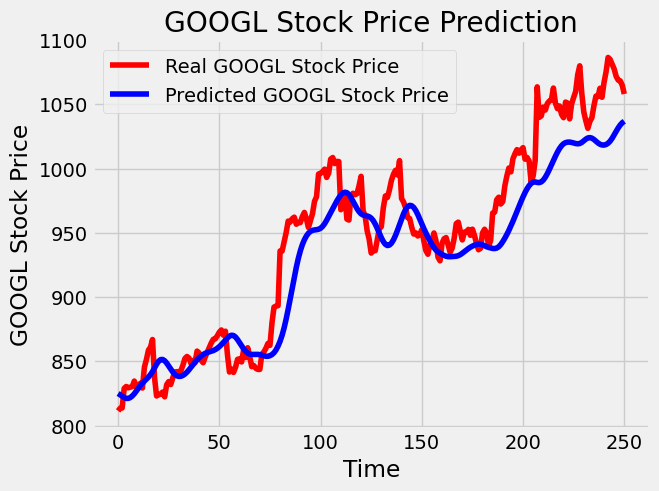

In [51]:
plot_predictions(test_set,predicted_stock_price)

Evaluating LSMT Model

In [52]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 28.649336292696077.


## GRU Model

In [53]:
# The GRU architecture
regressorGRU = Sequential()

# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))

# The output layer
regressorGRU.add(Dense(units=1))

# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=10,batch_size=150)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 540ms/step - loss: 0.0939
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 298ms/step - loss: 0.0211
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 573ms/step - loss: 0.0047
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 297ms/step - loss: 0.0037
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 427ms/step - loss: 0.0031
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 273ms/step - loss: 0.0029
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 304ms/step - loss: 0.0028
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 422ms/step - loss: 0.0023
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 276ms/step - loss: 0.0026
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 411ms/step - loss: 0.0026



## Make preductuion with GRU model

In [57]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = scaler.inverse_transform(GRU_predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Visualizing the Results

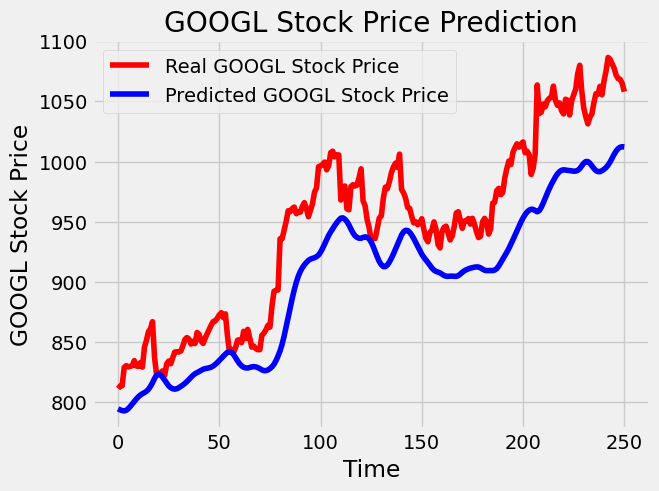

In [58]:
plot_predictions(test_set,GRU_predicted_stock_price)

Evaluating GRU Model

In [56]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 947.2003438273388.
